In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import gdown
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## **Block**

In [22]:
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_blocks, grow_rate, **kwargs):
        super().__init__(**kwargs)
        self.num_blocks = num_blocks
        self.grow_rate = grow_rate
        self.block_layers = []  # Placeholder for layers

    def build(self, input_shape):
        initializer = tf.keras.initializers.HeNormal()  # Weight initialization
        for _ in range(self.num_blocks):
            # Define layers for each block
            self.block_layers.append([
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.ReLU(),
                tf.keras.layers.Conv2D(filters=4 * self.grow_rate, kernel_size=(1, 1), padding='same'),
                tf.keras.layers.Dropout(0.2),  
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.ReLU(),
                tf.keras.layers.Conv2D(filters=self.grow_rate, kernel_size=(3, 3), padding='same'),
                tf.keras.layers.Dropout(0.2)
            ])

    def call(self, inputs):
        x = inputs
        for block in self.block_layers:
            block_input = x
            for layer in block:
                x = layer(x)
            x = tf.keras.layers.Concatenate(axis=-1)([block_input, x])
        return x


## **Transition Block**

In [23]:
class TransitionBlock(tf.keras.layers.Layer):
    def __init__(self, compression=0.5, **kwargs):
        super().__init__(**kwargs)
        self.compression = compression
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = None  # Initialize later when input shape is known
        self.avg_pool = tf.keras.layers.AvgPool2D(pool_size=(2, 2), strides=2)

    def build(self, input_shape):
        initializer = tf.keras.initializers.HeNormal()
        # Define Conv2D layer here because input_shape is now known
        reduced_filters = int(input_shape[-1] * self.compression)
        self.conv = tf.keras.layers.Conv2D(filters=reduced_filters, kernel_size=(1, 1), padding='same')
        super().build(input_shape)

    def call(self, inputs):
        x = self.bn(inputs)
        x = self.relu(x)
        x = self.conv(x)
        x = self.avg_pool(x)
        return x


## **DenseNet model**

In [24]:
DenseNet = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(50, 50, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (7,7), padding= 'same', strides = 2),
    tf.keras.layers.MaxPool2D(pool_size = (3,3), padding = 'same', strides = 2),

    DenseBlock(num_blocks = 6, grow_rate = 32),
    TransitionBlock(),
    DenseBlock(num_blocks = 12, grow_rate = 16),
    TransitionBlock(),
    DenseBlock(num_blocks = 24, grow_rate = 8),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [25]:
DenseNet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_174              │ (None, 50, 50, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_174 (ReLU)                     │ (None, 50, 50, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_174 (Conv2D)                  │ (None, 25, 25, 16)          │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_6 (DenseBlock)           │ (None, 13, 13, 208)         │         301,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_block_4 (TransitionBlock) │ (None, 6, 6, 104)           │          22,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_7 (DenseBlock)           │ (None, 6, 6, 296)           │         271,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_block_5 (TransitionBlock) │ (None, 3, 3, 148)           │          45,140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_8 (DenseBlock)           │ (None, 3, 3, 340)           │         266,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 340)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,705 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 909,449 (3.47 MB)

 Trainable params: 886,551 (3.38 MB)

 Non-trainable params: 22,898 (89.45 KB)

## **Dataset**

In [9]:
url1 = "https://drive.google.com/uc?id=1P4SYbafssKz-6oPXjqTD7aBiCawQjHEk"
output1 = "Y_N70000_lpx50_gqtwz.npz"

url2 = "https://drive.google.com/uc?id=1S_QInod3zyO8Vj-YGQfuM1eVPnwiIeRX"
output2 = "X_N70000_lpx50_gqtwz.npz"

gdown.download(url1, output1, quiet=False)
gdown.download(url2, output2, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1P4SYbafssKz-6oPXjqTD7aBiCawQjHEk
To: /kaggle/working/Y_N70000_lpx50_gqtwz.npz
100%|██████████| 1.12M/1.12M [00:00<00:00, 123MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1S_QInod3zyO8Vj-YGQfuM1eVPnwiIeRX
From (redirected): https://drive.google.com/uc?id=1S_QInod3zyO8Vj-YGQfuM1eVPnwiIeRX&confirm=t&uuid=5c2fe677-f6ef-4951-a36d-1825177a035f
To: /kaggle/working/X_N70000_lpx50_gqtwz.npz
100%|██████████| 1.40G/1.40G [00:11<00:00, 125MB/s] 


'X_N70000_lpx50_gqtwz.npz'

In [26]:
X_Data = np.load("X_N70000_lpx50_gqtwz.npz")["arr_0"]
Y_Data = np.load("Y_N70000_lpx50_gqtwz.npz")["arr_0"][:,0] # took only the feature about the class of the particle, it cuts the mass

## **Data Pre-processing**

In [28]:
# data split
num_images = X_Data.shape[0] # Total number of Datapoints

train_end = int(0.6 * num_images)
test_end = train_end + int(0.2 * num_images)

X_train, X_test, X_val = X_Data[:train_end], X_Data[train_end:test_end], X_Data[test_end:]
Y_train, Y_test, Y_val = Y_Data[:train_end], Y_Data[train_end:test_end], Y_Data[test_end:]

# one hot encoding the lables
one_hot_encoder = OneHotEncoder(sparse_output=False)
Y_train_onehot = one_hot_encoder.fit_transform(Y_train.reshape((-1,1)))
Y_valid_onehot = one_hot_encoder.fit_transform(Y_val.reshape((-1,1)))
Y_test_onehot = one_hot_encoder.fit_transform(Y_test.reshape((-1,1)))

In [29]:
print(X_train.shape)

(42000, 50, 50)


In [30]:
def lr_schedule(epoch, lr):
    total_epochs = 40  # Example total number of epochs
    if epoch < total_epochs * 0.5:
        return 0.1
    elif epoch < total_epochs * 0.75:
        return 0.1 / 10
    else:
        return 0.1 / 100

In [31]:
DenseNet.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True, weight_decay=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [33]:
history = DenseNet.fit(
    X_train,
    Y_train_onehot,
    epochs=40,
    batch_size=64,
    callbacks=[lr_callback],
    validation_data=(X_val, Y_valid_onehot))

Epoch 1/40
657/657 ━━━━━━━━━━━━━━━━━━━━ 242s 181ms/step - accuracy: 0.4818 - loss: 1.2933 - val_accuracy: 0.2067 - val_loss: 7.6330 - learning_rate: 0.1000
Epoch 2/40
657/657 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.5974 - loss: 1.0398 - val_accuracy: 0.5041 - val_loss: 1.4146 - learning_rate: 0.1000
Epoch 3/40
657/657 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.6293 - loss: 0.9824 - val_accuracy: 0.5188 - val_loss: 1.4092 - learning_rate: 0.1000
Epoch 4/40
657/657 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.6471 - loss: 0.9461 - val_accuracy: 0.3151 - val_loss: 2.3498 - learning_rate: 0.1000
Epoch 5/40
657/657 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.6580 - loss: 0.9179 - val_accuracy: 0.6444 - val_loss: 0.9769 - learning_rate: 0.1000
Epoch 6/40
657/657 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.6641 - loss: 0.9053 - val_accuracy: 0.3363 - val_loss: 2.1489 - learning_rate: 0.1000
Epoch 7/40
657/657 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.6677 -

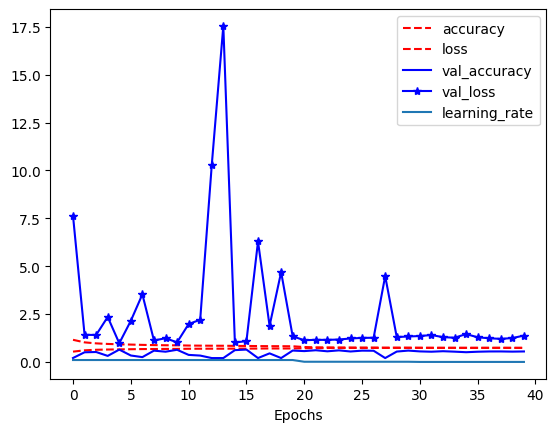

In [34]:
hist = pd.DataFrame(history.history)
hist.plot(xlabel = 'Epochs', style = ['r--', 'r--', 'b-', 'b-*'])
plt.show()

In [35]:
DenseNet.evaluate(X_test, Y_test_onehot)

438/438 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5593 - loss: 1.3716


[1.3734920024871826, 0.5559999942779541]